In [1]:
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np 
import pickle

### Internal classes
from loaders import ItemLoader
from items import Item 

/Volumes/VTG/Dev/C_5/Projects/week6/data_curation-optimization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
%matplotlib inline

In [3]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN_KEY = os.getenv("HF_TOKEN")

In [4]:
login(HF_TOKEN_KEY, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
items = ItemLoader("Electronics").load()

print(items[0].prompt)

print(len(items))

Loading dataset: Electronics


  0%|                                                                            | 0/162 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed Electronics with 477,816 datapoints in 2.8 mins
How much does this cost to the nearest dollar?

Digi-Tatoo Decal Skin Compatible With MacBook Pro 13 inch (Model A2338/ A2289/ A2251) - Protective and Decorative Full Body Laptop Skin Decal Sticker, Anti-Scratch Vinly Skin Sticker Wrap  Fresh Marble
WARNING  Please IDENTIFY MODEL NUMBER on the bottom of your Macbook. Only fits for model A2338/ A2289/ A2251 (Macbook Pro 13" w/ Touch Bar, release). Extra Care Yet Not Bulky. Our skin is capable of protecting the surface of your Macbook from daily scratches, dust, oil, water and fingerprint. Your Macbook remains fresh some years later. Elegant Style. Our stylish design and printing tech give your Macbook a 360 degree decorative and

Price is $20.00
477816


## Scale Up -- All Different Categories Into One List

In [6]:
dataset_names = [
    "All_Beauty", "Arts_Crafts_and_Sewing", "Cell_Phones_and_Accessories", 
    "Electronics", "Gift_Cards", "Handmade_Products", "Industrial_and_Scientific", 
    "Musical_Instruments", "Toys_and_Games"
]

In [7]:
items = [] 
for dataset_name in dataset_names: 
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset: All_Beauty


  0%|                                                                             | 0/12 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed All_Beauty with 6,522 datapoints in 0.1 mins
Loading dataset: Arts_Crafts_and_Sewing


  0%|                                                                             | 0/81 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed Arts_Crafts_and_Sewing with 331,924 datapoints in 1.1 mins
Loading dataset: Cell_Phones_and_Accessories


  0%|                                                                            | 0/129 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed Cell_Phones_and_Accessories with 245,210 datapoints in 1.8 mins
Loading dataset: Electronics


  0%|                                                                            | 0/162 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed Electronics with 477,816 datapoints in 3.0 mins
Loading dataset: Gift_Cards


100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]

Completed Gift_Cards with 339 datapoints in 0.1 mins
Loading dataset: Handmade_Products



  0%|                                                                             | 0/17 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tok

Completed Handmade_Products with 68,440 datapoints in 0.3 mins
Loading dataset: Industrial_and_Scientific


  0%|                                                                             | 0/43 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed Industrial_and_Scientific with 190,990 datapoints in 0.7 mins
Loading dataset: Musical_Instruments


  0%|                                                                             | 0/22 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed Musical_Instruments with 74,435 datapoints in 0.3 mins
Loading dataset: Toys_and_Games


  0%|                                                                             | 0/90 [00:00<?, ?it/s]None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only toke

Completed Toys_and_Games with 367,700 datapoints in 1.6 mins


In [8]:
print(f"Grand Total of {len(items):,} Items.")

Grand Total of 1,763,376 Items.


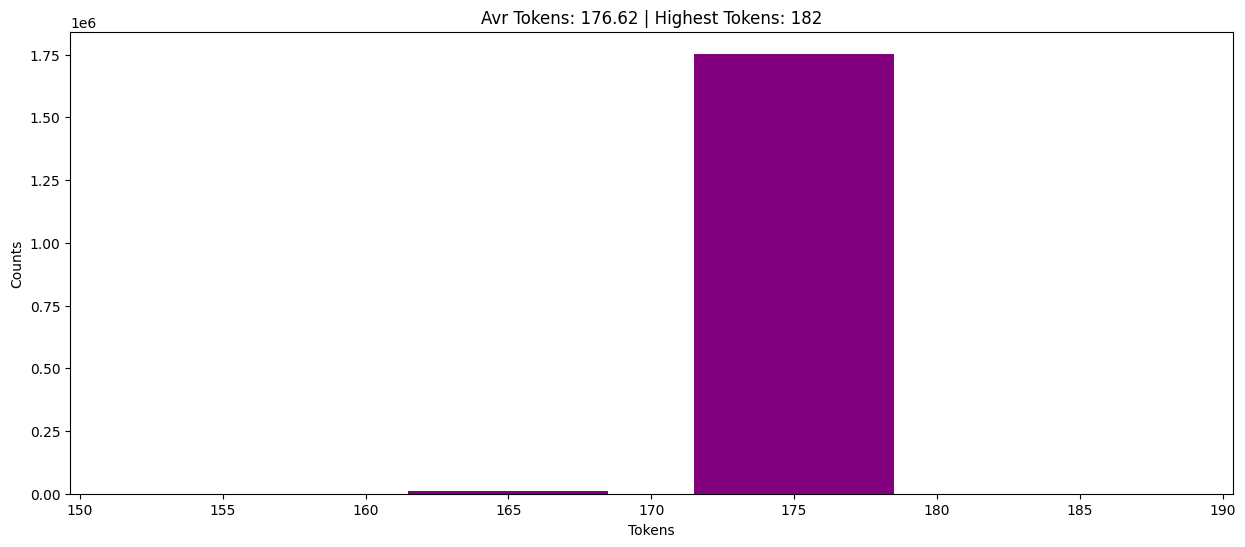

In [9]:
### Count tokens -- Avr and highest out of the all items 
tokens = [item.token_count for item in items]

plt.figure(figsize=(15, 6))
plt.title(f"Avr Tokens: {sum(tokens) / len(tokens):.2f} | Highest Tokens: {max(tokens)}")
plt.xlabel("Tokens")
plt.ylabel("Counts")
plt.hist(tokens, rwidth=0.7, color="purple", bins = range(150, 200, 10))
plt.show()

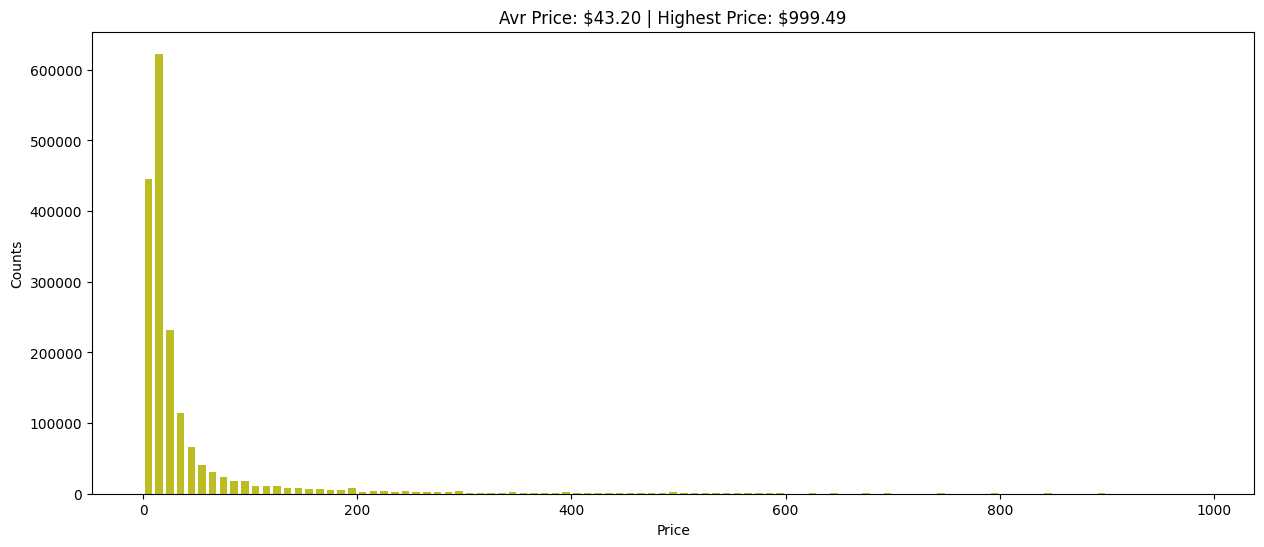

In [10]:
### Price distribution out of the all items
### (Avr price and highest)

prices = [item.price for item in items]

plt.figure(figsize=(15, 6))
plt.title(f"Avr Price: \\${sum(prices) / len(prices):,.2f} | Highest Price: ${max(prices):,}")
plt.xlabel("Price")
plt.ylabel("Counts")
plt.hist(prices, rwidth=0.7, color="C8", bins=range(0, 1000, 10))
plt.show()

In [11]:
print(items[1])

<BioMiracle StarDust Pixie Bubble Mask, Clarifying Foaming Face Mask with Green Tea and Apple, Carbonated Bubble Cupro Sheet Mask for Clear, Even Skin = $5.99>


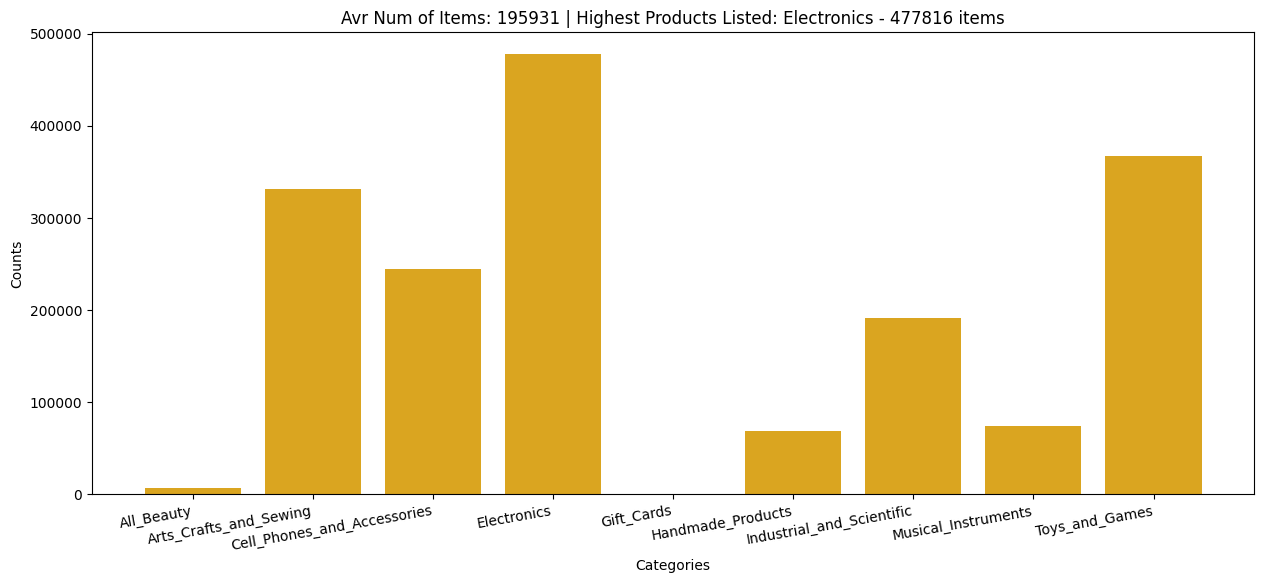

In [12]:
raw_categories = [item.category for item in items]

counter = Counter(raw_categories)

### Category with the highest number of items
top_category = counter.most_common(1)

### keys and values - keys: categories | values: item counts
# key_list = [k for k, v in counter.items()]
# value_list = [v for k, v in counter.items()]

categories, counts = zip(*counter.items())

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title(f"Avr Num of Items: {round(counter.total() / len(categories))} | Highest Products Listed: {top_category[0][0]} - {top_category[0][1]} items")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(rotation=10, ha="right")
plt.show()

In [13]:
print(items[0])

<Lurrose 100Pcs Full Cover Fake Toenails Artificial Transparent Nail Tips Nail Art for DIY = $6.99>


## Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [14]:
slots = defaultdict(list)
for item in items: 
    slots[round(item.price)].append(item)


In [25]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)

samples = []

for i in range(1, 1000): 
    slot = slots[i]
    if i >= 240:
        samples.extend(slot) 
    elif len(slot) <= 1200: 
        samples.extend(slot) 
    else: 
        weights = np.array([1 if item.category == "Electronics" else 5 for item in slot])
        weights = weights / sum(weights) 
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights) 
        selected = [slot[i] for i in selected_indices]
        samples.extend(selected)
        
print(f"There are {len(samples):,} items in the sample")
        

There are 246,160 items in the sample


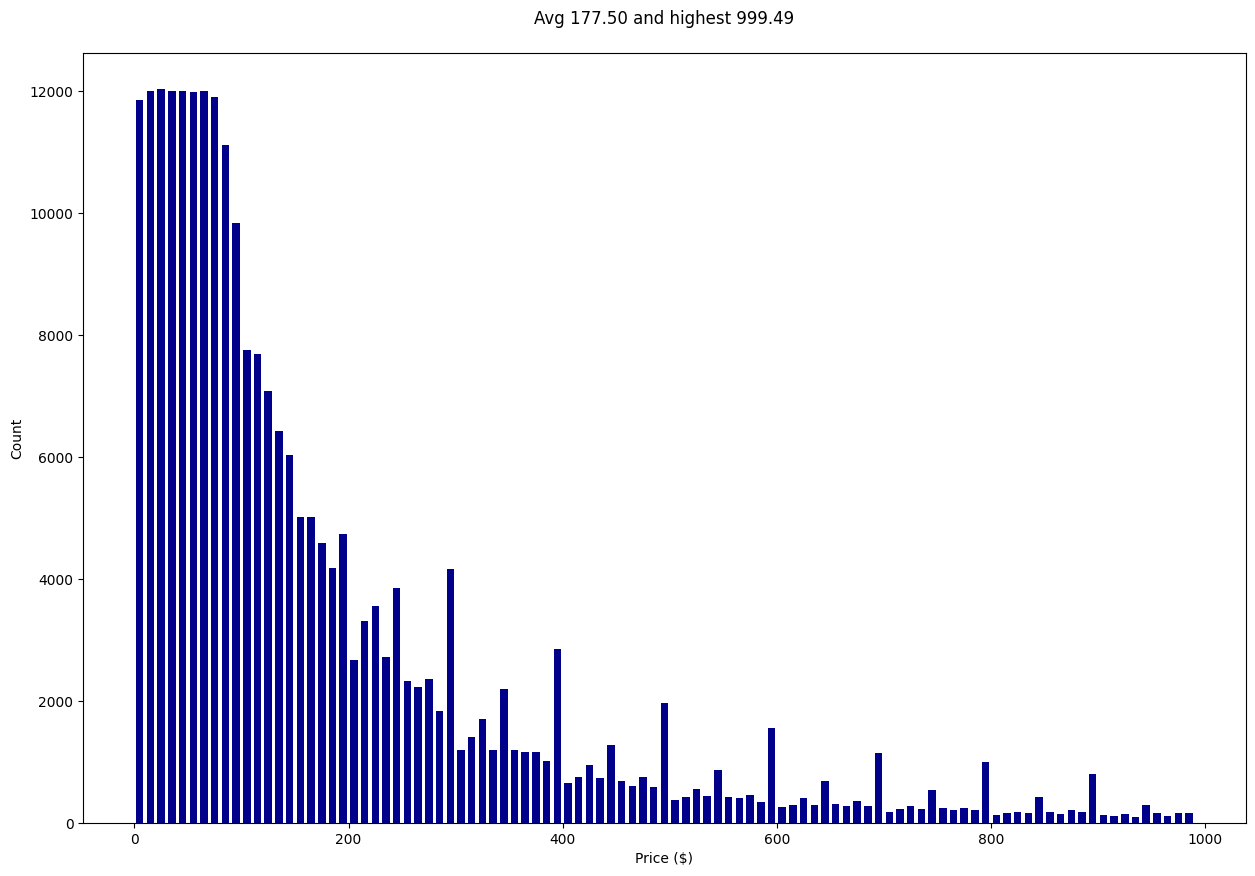

In [31]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in samples]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

Counter({'Electronics': 80635, 'Toys_and_Games': 51804, 'Industrial_and_Scientific': 37199, 'Arts_Crafts_and_Sewing': 27021, 'Musical_Instruments': 26692, 'Cell_Phones_and_Accessories': 12550, 'Handmade_Products': 9508, 'All_Beauty': 701, 'Gift_Cards': 50})


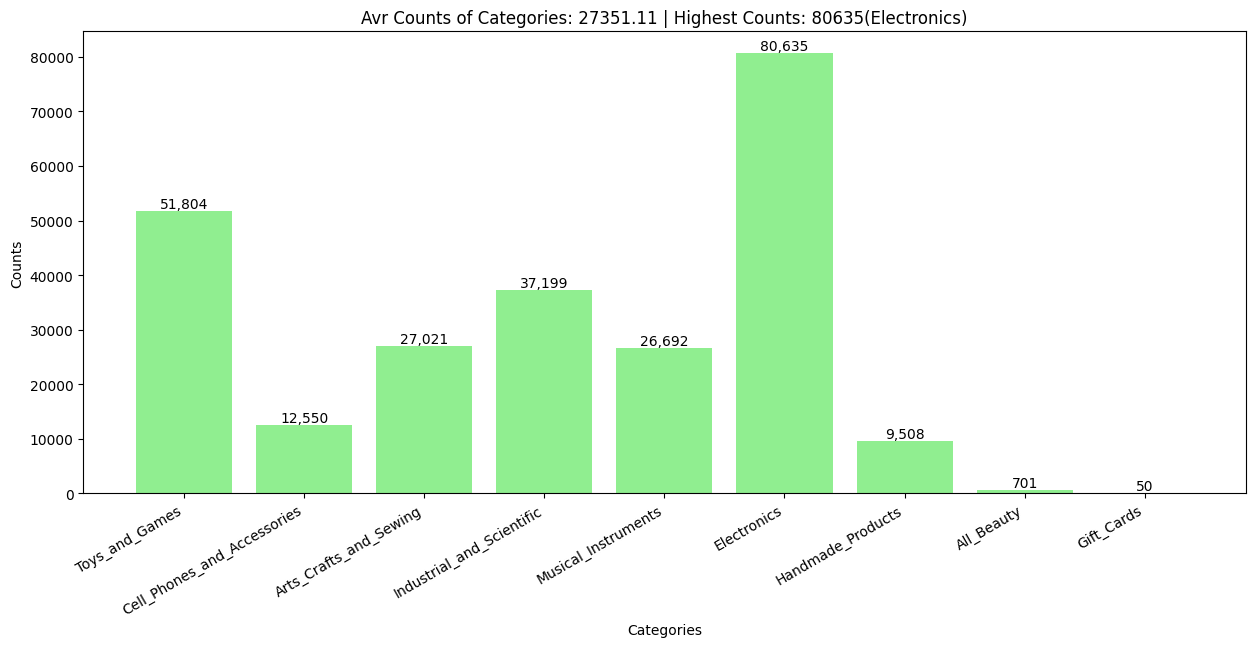

In [85]:
### Category Counter 

categories = [item.category for item in samples]

category_counter = Counter(categories) 

### Separate categories and counts 
cats, counts = zip(*category_counter.items())
### Category with the highest counts
highest_key = category_counter.most_common(1)

### Bar Chart:
plt.figure(figsize=(15, 6))
plt.bar(cats, counts, color="lightgreen")
plt.title(f"Avr Counts of Categories: {sum(counts) / len(counts):.2f} | Highest Counts: {max(counts)}({highest_key[0][0]})")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(rotation=30, ha="right")


### Add labels on top of each bar 
for i, v in enumerate(counts): 
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

plt.show()


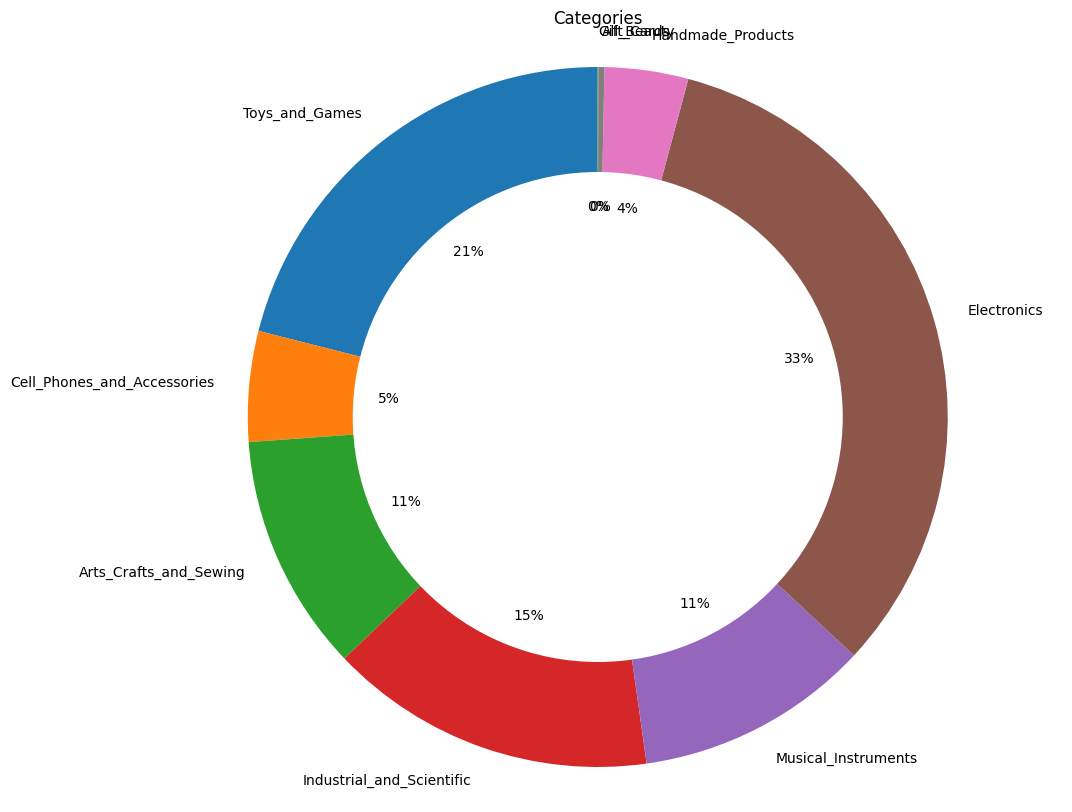

In [87]:
### Pie chart

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=cats, autopct='%1.0f%%', startangle=90)

### Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

### Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()